# Proiect Inteligență Artificială - Clasificatorul SVM
## Tiberiu Maxim, grupa 351
### SUBMISIA 1 - (Public: 0.79721, Private: 0.76438)

### PIP INSTALL

In [1]:
# ! pip install ...

! pip install pyphen
! pip install nltk
! pip install openpyxl
! pip install gensim
! pip install Inflector

     |████████████████████████████████| 2.0 MB 26.8 MB/s            
     |████████████████████████████████| 1.5 MB 26.3 MB/s            
     |████████████████████████████████| 242 kB 31.0 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for Inflector: filename=Inflector-3.0.1-py3-none-any.whl size=12974 sha256=196338577d0acb8cc5fee5f96adbeb89abf0a654a8040a96e62bbb8db8022e68
  Stored in directory: /home/datalore/.cache/pip/wheels/95/9e/33/4562340de94527eed6cf4adfa02365ac4e9ce610774559fa56
Successfully built Inflector


### IMPORTS

In [2]:
# basic imports

import numpy as np
import pandas as pd
import os
from timeit import timeit

In [3]:
# imports used in some features

from pyphen import Pyphen
from inflector import Inflector, English
from dale_chall import DALE_CHALL

In [4]:
# nltk downloads

import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/datalore/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/datalore/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
# nltk imports

from nltk.corpus import wordnet as wn

In [6]:
# scikit-learn imports

# svm
from sklearn.svm import SVC

# metrics
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# utils
from sklearn.utils import shuffle

# model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [7]:
# gensim imports

from gensim.utils import tokenize
from gensim.parsing.preprocessing import STOPWORDS

### READING DATA FROM FILES

In [8]:
path = '/data/notebook_files/project_data/'

dtypes = {'corpus': 'string', 'sentence': 'string', 'token': 'string', 'complex': 'float64'}
train_data = pd.read_excel(os.path.join(path, 'train.xlsx'), dtype=dtypes, keep_default_na=False)
test_data = pd.read_excel(os.path.join(path, 'test.xlsx'), dtype=dtypes, keep_default_na=False)

# train_data must be shuffled
for _ in range(10):
    train_data = shuffle(train_data).reset_index(drop=True)

In [9]:
# wordForms
word_forms = pd.read_excel('/data/notebook_files/wordForms.xlsx')
word_forms = np.array(word_forms)

# stopwords
stopwords = STOPWORDS

### DATA STATS

In [10]:
print('Train data: ', train_data.shape)
print('Test data: ', test_data.shape)

Train data:  (7662, 4)
Test data:  (1338, 3)


In [11]:
train_data.head()

,corpus,sentence,token,complex
0,biomed,"More importantly, sequencing hg modifier candi...",sequencing,0.0
1,europarl,Accession of Liechtenstein to the Agreement be...,Liechtenstein,1.0
2,bible,The seed of Israel separated themselves from a...,iniquities,0.0
3,biomed,One report of a duplication of the region of h...,duplication,0.0
4,biomed,Animals carrying the at allele express only th...,middle,0.0


In [12]:
test_data.head()

,corpus,sentence,token
0,europarl,Non-proliferation Treaty (vote),Treaty
1,europarl,"(SV) Mr President, if you went into the corrid...",stickers
2,biomed,AK and NL performed bile collection experiment...,AK
3,biomed,"However, the lack of association of transcript...",smoking
4,biomed,ADAM11-deficient mice survived more than one y...,tremor


### FEATURE GENERATING FUNCTIONS WHOSE RESULTS CAN BE ADDED TO THE VECTOR

In [13]:
def corpus_feature(corpus):
    if corpus == 'bible':
        return [0]
    elif corpus == 'biomed':
        return [1]
    else:
        return [2]

In [14]:
def word_length(word):
    return len(word)

In [15]:
def number_of_vowels(word):
    count = 0
    word = word.upper()
    vowels = 'AEIOU'

    for char in word:
        if char in vowels:
            count += 1
    
    return count

In [16]:
def is_consonant(char):
    char = char.upper()
    vowels = 'AEIOU'

    return not char in vowels and 65 <= ord(char) <= 90

def number_of_consonants(word):
    count = 0

    for char in word:
        if is_consonant(char):
            count += 1
    
    return count

In [17]:
def number_of_special_chars(word):
    count = 0

    for char in word:
        if char.isalpha() or char.isdigit():
            continue
        else:
            count += 1
    
    return count

In [18]:
def number_of_syllables(word):
    lang = Pyphen(lang='en')
    return len(lang.inserted(word, '-').split('-'))

In [19]:
def is_title(word):
    return int(word.istitle())

In [20]:
def is_dale_chall(word):
    return int(word.lower() in DALE_CHALL)

In [21]:
def is_word_forms(word):
    return int(word.lower() in word_forms)

In [22]:
def is_stopword(word):
    return int(word in stopwords)

In [23]:
def get_all_tokens(_df):
    words = []

    for _, item in _df.iterrows():
        tokens = tokenize(item['sentence'])

        for token in tokens:
            words.append(token)
    
    return words

In [24]:
def get_word_frequency(word, words):
    inflector = Inflector(English)
    return words.count(inflector.singularize(word)) / len(words) * 100

In [25]:
def synsets(word):
    return len(wn.synsets(word))

In [26]:
def hypernyms(word):
    count = 0
    for ss in wn.synsets(word):
        count += len(ss.hypernyms())
    return count

In [27]:
def hyponyms(word):
    count = 0
    for ss in wn.synsets(word):
        count += len(ss.hyponyms())
    return count

In [28]:
def meronyms(word):
    count = 0
    for ss in wn.synsets(word):
        count += len(ss.part_meronyms())
    return count

In [29]:
def holonyms(word):
    count = 0
    for ss in wn.synsets(word):
        count += len(ss.part_holonyms())
    return count

### FEATURIZE FUNCTIONS

In [30]:
all_words = get_all_tokens(train_data) + get_all_tokens(test_data)

def get_word_structure_features(word):
    features = [
        word_length(word), 
        number_of_vowels(word), 
        number_of_consonants(word),
        number_of_special_chars(word), 
        number_of_syllables(word),
        is_title(word),
        is_dale_chall(word),
        is_word_forms(word),
        is_stopword(word),
        get_word_frequency(word, all_words)
    ]

    return np.array(features)

In [31]:
def get_wordnet_features(word):
    features = [
        synsets(word),
        hypernyms(word),
        hyponyms(word),
        meronyms(word),
        holonyms(word)
    ]

    return np.array(features)

In [32]:
def featurize_row(row):
    word = row['token']

    all_features = []
    all_features.extend(corpus_feature(row['corpus']))
    all_features.extend(get_word_structure_features(word))
    all_features.extend(get_wordnet_features(word))

    return np.array(all_features)

In [33]:
def featurize_df(_df):
    number_of_features = len(featurize_row(_df.iloc[0]))
    number_of_examples = len(_df)
    features = np.zeros((number_of_examples, number_of_features))

    for index, row in _df.iterrows():
        row_features = featurize_row(row)
        features[index, :] = row_features

    return features

### FEATURE train_data & EXTRACT TARGET FROM train_data

In [34]:
X = featurize_df(train_data)
y = train_data['complex'].values

### STATS ABOUT THE FEATURED train_data

In [35]:
print(X.shape)
print(y.shape)

(7662, 16)
(7662,)


## SVM CLASSIFIER

### TRAIN-TEST SPLITTING FOR EVALUATING PERFORMANCE

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [37]:
# training on X_train | y_train 
svc_model = SVC(C=10, gamma='auto', kernel='rbf', class_weight='balanced')
svc_model.fit(X_train, y_train)

SVC(C=10, class_weight='balanced', gamma='auto')

### EVALUATING THE PERFORMANCE

In [38]:
test_predicitions = svc_model.predict(X_test)

In [39]:
print(svc_model.score(X_test, y_test))

0.8264840182648402


In [40]:
test_balanced_accuracy_score = balanced_accuracy_score(y_test, test_predicitions)
print(test_balanced_accuracy_score)

0.7961320545104429


In [41]:
test_confusion_matrix = confusion_matrix(y_test, test_predicitions)
print(test_confusion_matrix)

[[1148  228]
 [  38  119]]


In [42]:
print(test_predicitions.sum())

347.0


### FINAL PREDICTIONS

In [43]:
X_test = featurize_df(test_data)

svc_model = SVC(C=10, gamma='auto', kernel='rbf', class_weight='balanced')
svc_model.fit(X, y)
predictions = svc_model.predict(X_test)
test_id = np.arange(7663, 9001)

df = pd.DataFrame()
df['id'] = test_id
df['complex'] = predictions

results_path = '/data/notebook_files/results/'
df.to_csv(os.path.join(results_path, 'submission-svm.csv'), index=False)

In [44]:
print(predictions.sum())

315.0


### 10-FOLDS CROSS VALIDATION

In [45]:
# 10-folds cross validation

cross_validation = KFold(n_splits=10, random_state=1, shuffle=True)
svc_model = SVC(C=10, gamma='auto', kernel='rbf', class_weight='balanced')
print(cross_val_score(svc_model, X, y, cv=cross_validation, scoring='balanced_accuracy', n_jobs=-1).mean())

0.8215009522846881


### CONFUSION MATRIX

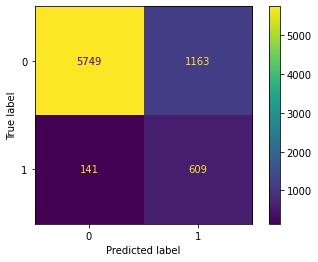

In [46]:
# confusion matrix

svc_model = SVC(C=10, gamma='auto', kernel='rbf', class_weight='balanced')
cross_validation = KFold(n_splits=10, random_state=1, shuffle=True)

predictions = cross_val_predict(estimator=svc_model, X=X, y=y, cv=cross_validation)

final_confusion_matrix = confusion_matrix(y_true=y, y_pred=predictions)
confusion_matrix_display = ConfusionMatrixDisplay(final_confusion_matrix, display_labels=[0, 1])
confusion_matrix_display.plot()

### TRAINING TIME

In [53]:
# training time

svc_model = SVC(C=10, gamma='auto', kernel='rbf', class_weight='balanced')
print('Training time: %fs.' % (timeit(lambda: svc_model.fit(X, y), number=100) / 100))

Training time: 1.549333s.


### TUNING THE HYPERPARAMETERS OF SVC() ESTIMATOR

In [50]:
param_grid = {'C' : [10, 11, 12]}
svc_model = SVC(gamma='auto', kernel='rbf', class_weight='balanced')
cross_validation = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
grid_search = GridSearchCV(estimator=svc_model, param_grid=param_grid, n_jobs=-1, cv=cross_validation, scoring='balanced_accuracy')

grid_search_results = grid_search.fit(X, y)
print('Best: %f using %s' % (grid_search_results.best_score_, grid_search_results.best_params_))

Best: 0.832467 using {'C': 10}
